In [1]:
from gurobipy import *
import numpy as np

In [14]:
horizon = [i for i in range(0,10)]

In [5]:
model = Model('test')

Academic license - for non-commercial use only


In [15]:
r = model.addVars(horizon, ub=1.0, name="valve")

In [17]:
r

{0: <gurobi.Var *Awaiting Model Update*>,
 1: <gurobi.Var *Awaiting Model Update*>,
 2: <gurobi.Var *Awaiting Model Update*>,
 3: <gurobi.Var *Awaiting Model Update*>,
 4: <gurobi.Var *Awaiting Model Update*>,
 5: <gurobi.Var *Awaiting Model Update*>,
 6: <gurobi.Var *Awaiting Model Update*>,
 7: <gurobi.Var *Awaiting Model Update*>,
 8: <gurobi.Var *Awaiting Model Update*>,
 9: <gurobi.Var *Awaiting Model Update*>}

In [18]:
years = tuplelist(range(2+1))
skill_levels = [0, 1, 2]  # 0 = Unskilled, 1 = Semiskilled, 2 = Skilled
Unskilled = 0
Semiskilled = 1
Skilled = 2

CurrentStrength = [2000, 1500, 1000]
Requirement = [[1000, 1400, 1000],
               [500, 2000, 1500],
               [0, 2500, 2000]]
LeaveFirstYear = [0.25, 0.20, 0.10]
LeaveEachYear = [0.10, 0.05, 0.05]
ContinueFirstYear = [1 - a for a in LeaveFirstYear]
ContinueEachYear = [1 - a for a in LeaveEachYear]
LeaveDownGraded = 0.50
ContinueDownGraded = 1 - LeaveDownGraded
MaxRecruit = [500, 800, 500]
MaxRetrainUnskilled = 200
MaxOverManning = 150
MaxShortTimeWorking = 50
RetrainSemiSkilled = 0.25
ShortTimeUsage = 0.50

RetrainCost = [400, 500, 0]
RedundantCost = [200, 500, 500]
ShortTimeCost = [500, 400, 400]
OverManningCost = [1500, 2000, 3000]

In [20]:
MaxRecruit2 = {(level, year) : MaxRecruit[level] for level in skill_levels for year in years}
model = Model('Manpower planning')

Recruit = model.addVars(skill_levels, years, ub= MaxRecruit2, name="Recruit")
ShortTime = model.addVars(skill_levels, years, ub=MaxShortTimeWorking,
                          name="ShortTime")
LaborForce = model.addVars(skill_levels, years, name="LaborForce")
Redundant = model.addVars(skill_levels, years, name="Redundant")
OverManned = model.addVars(skill_levels, years, name="OverManned")
Retrain = model.addVars(skill_levels, skill_levels, years, name="Retrain")

In [37]:
x = np.linspace(0, 500, 1000)
y = np.sqrt(x)

In [38]:
import matplotlib.pyplot as plt

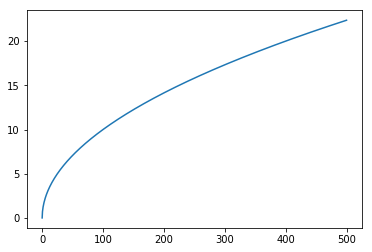

In [39]:
plt.plot(x,y)

In [40]:
p = np.polyfit(x,y,2)

In [41]:
y1 = x**2 *p[0] + x*p[1] +p[2]

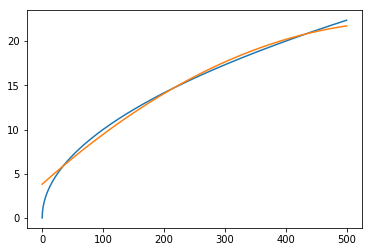

In [42]:
plt.plot(x,y)
plt.plot(x,y1)

In [43]:
p

array([-5.13182053e-05,  6.14647148e-02,  3.81572575e+00])

In [6]:
from gurobipy import *
import numpy  as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

# Common Containers and variables 
volumns  = {}
outflows = {}
horizon  = [time for time in range(0, 20)]  # Time steps

# Pond1 -> Generate outflows
## Variables 
m_p1       = Model("Pond1")
volume_p1  = m_p1.addVars(horizon, lb=0, ub=100, vtype=GRB.CONTINUOUS, name="Volume")
outflow_p1 = m_p1.addVars(horizon, lb=0, ub=10 , vtype=GRB.CONTINUOUS, name="Outflows")

# Constarints 
m_p1.addConstr(volume_p1[0] == 90, "Inital Volume")
m_p1.addConstr(outflow_p1.sum() <= 100, "Total Mass Movement")
m_p1.addConstrs((volume_p1[time] == volume_p1[time-1] - outflow_p1[time-1] for time in horizon[1:]), name="Mass balance")
m_p1.addConstrs(outflow_p1[time] <= (volume_p1[time-1]*6.14647148e-02 + 3.81)*0.447 for time in horizon[1:])

# Objective 
m_p1.setObjective(volume_p1.sum(), GRB.MINIMIZE)
m_p1.optimize()


# Pond2 -> Generate Outflows 
## Variables 
m_p2       = Model("Pond2")
volume_p2  = m_p2.addVars(horizon, lb=0, ub=100, vtype=GRB.CONTINUOUS, name="Volume")
outflow_p2 = m_p2.addVars(horizon, lb=0, ub=10 , vtype=GRB.CONTINUOUS, name="Outflows")

# Constarints 
m_p2.addConstr(volume_p2[0] == 90, "Inital Volume")
m_p2.addConstr(outflow_p2.sum() <= 100, "Total Mass Movement")
m_p2.addConstrs((volume_p2[time] == volume_p2[time-1] - outflow_p2[time-1] for time in horizon[1:]), name="Mass balance")
m_p2.addConstrs(outflow_p2[time] <= (volume_p2[time-1]*6.14647148e-02 + 3.81)*0.447 for time in horizon[1:])

# Objective 
m_p2.setObjective(volume_p2.sum(), GRB.MINIMIZE)
m_p2.optimize()


# Pond3 -> Take in the outflows and plan how you want to release them.
## Generate the outflows from the above into the downstream 
inflow_p1 = [outflow_p1[i].x for i in outflow_p1.keys()]
inflow_p2 = [outflow_p2[i].x for i in outflow_p2.keys()]
inflows = np.zeros(20)
inflows = inflows[10:] + np.asarray(inflow_p1[:10]) + np.asarray(inflow_p2[:10]) 


Optimize a model with 40 rows, 40 columns and 116 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+01, 1e+02]
  RHS range        [2e+00, 1e+02]
Presolve removed 26 rows and 24 columns
Presolve time: 0.01s
Presolved: 14 rows, 16 columns, 109 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.3156466e+01   1.000000e+01   0.000000e+00      0s
      14    1.0196863e+03   0.000000e+00   0.000000e+00      0s

Solved in 14 iterations and 0.02 seconds
Optimal objective  1.019686300e+03
Optimize a model with 40 rows, 40 columns and 116 nonzeros
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+01, 1e+02]
  RHS range        [2e+00, 1e+02]
Presolve removed 26 rows and 24 columns
Presolve time: 0.01s
Presolved: 14 rows, 16 columns, 109 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.3

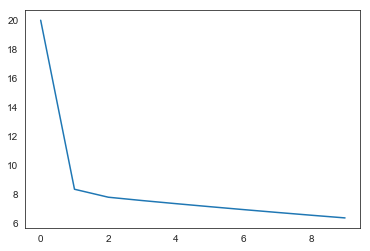

In [7]:
plt.plot(inflows)

In [9]:
inflow_p1 = [outflow_p1[i].x for i in outflow_p1.keys()]
inflow_p2 = [outflow_p2[i].x for i in outflow_p2.keys()]
inflows = np.zeros(20)

In [17]:
inflows[10:] = inflows[10:] + inflow_p1[:10] + inflow_p2[:10]

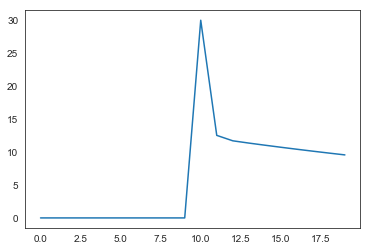

In [18]:
plt.plot(inflows)